In [160]:
# IMPORT STATEMENTS
import cv2
import re
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.patches as patches
import matplotlib.colors as colors
import PIL
import math
get_ipython().magic('matplotlib inline')
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
#sns.set_theme(style="whitegrid")
import json
from scipy.stats import fisher_exact, ttest_ind
from collections import Counter
from sklearn.linear_model import LinearRegression
from pprint import pprint
import os
import pickle
import sys
import plotnine as p9
sys.path.append("/booleanfs/sahoo/scripts/")
sys.path.append("/booleanfs2/sahoo/Hegemon/")
sys.path.append("/booleanfs2/sahoo/BoNE")
import StepMiner as smn
import HegemonUtil as hu
from scipy.stats import hypergeom
acolor = ["#00CC00", "#D8A03D","#EC008C",
          'cyan', "#B741DC", "#808285",
          'blue', 'black', 'green', 'red',
          'orange', 'brown', 'pink', 'purple']

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3     

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import gc_mod
reload(gc_mod)
import Utils as ut
import bone
reload(bone)

<module 'bone' from '/mnt/Users/sinha7290/public_html/BoNE/bone.py'>

In [161]:
import bone
reload(bone)
class MacAnalysis(bone.IBDAnalysis):

    def __init__(self):
        bone.MacAnalysis.__init__(self)
   
 

    def getBos(self, tn=1, tb=0):
        self.prepareData("BC20", "/Users/sinha7290/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('c Relapse')
        atypes = ['0', '1']
        ahash = {'1':1, '0':0}
        self.initData(atype, atypes, ahash)
        return
    
    def getAmado1TT(self, tn=1):
        self.prepareData("SS66","/Users/sinha7290/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('c ifih1-rs1990760 (ch1)')
        #ahash = {'IgG CTC chip': 0}
        ahash = {'TT': 0}
        hval = [1 if i in ahash else None for i in atype]         
        atype = self.h.getSurvName('ArrayId')
        atypes = ['Low', 'High']
        ahash = {'GSM5137952': 0,'GSM5137959': 0,'GSM5137958': 0,'GSM5137980': 0,'GSM5137983': 0,'GSM5137984': 0,'GSM5137947': 1,'GSM5137956': 1,'GSM5137963': 1,'GSM5137966': 1,'GSM5137982': 1}
        atype = [atype[i] if hval[i] == 1
                else None for i in range(len(atype))]   
        self.initData(atype, atypes, ahash)
    
    def getAmado2T(self, tn=1):
        self.prepareData("SS67","/Users/sinha7290/public_html/Hegemon/explore.conf")
        atype = self.h.getSurvName('c corticosteroids treatment (ch1)')
        #ahash = {'IgG CTC chip': 0}
        ahash = {'1': 0}
        hval = [1 if i in ahash else None for i in atype]         
        atype = self.h.getSurvName('c ifih1-rs1990760 (ch1)')
        atypes = ['TT', 'CT', 'CC']
        ahash = {'TT':0, 'CT':1, 'CC':2}
        atype = [atype[i] if hval[i] == 1
                else None for i in range(len(atype))]   
        self.initData(atype, atypes, ahash)
    

def printOLS(fm, df1):
    import statsmodels.formula.api as smf
    lm1 = smf.ols(formula=fm, data=df1).fit()
    print(lm1.summary())
    idx = lm1.params.index
    ci = lm1.conf_int()
    ci_1 = [ ci[0][i] for i in range(len(idx))]
    ci_2 = [ ci[1][i] for i in range(len(idx))]
    c_1 = [ getCode(p) for p in lm1.pvalues]
    df = pd.DataFrame({'Name': idx, 
    'coeff' : lm1.params, 'lower 0.95' : ci_1,
        'upper 0.95' : ci_2, 'pvalues' : lm1.pvalues, 'codes': c_1},
        columns=['Name', 'coeff', 'lower 0.95',
        'upper 0.95', 'pvalues', 'codes'])
    for i in range(len(idx)):
        print('%s\t%.2f\t(%0.2f - %0.2f)\t%0.3f' % \
                (idx[i], lm1.params[i], ci[0][i], ci[1][i], lm1.pvalues[i]))
    print(df.to_string(formatters={'coeff':'{:,.2f}'.format,
        'lower 0.95':'{:,.2f}'.format, 'upper 0.95':'{:,.2f}'.format,
        'pvalues': '{:,.3f}'.format}))
    return df    

    
def plotViolinBar(ana, desc=None):
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig

def plotDensityBar(ana, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getMetrics(ana.cval[0])
    ax.text(len(ana.cval[0]), 4, ",".join(res))
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    ax = ana.densityPlot(ax2, acolor)
    return fig

def processData(ana, l1, wt1, desc=None, violin=1):
    ana.orderData(l1, wt1)
    if (violin == 1):
        return plotViolinBar(ana, desc)
    return plotDensityBar(ana, desc)

def processDataDf(ana, l1, wt1, desc=None):
    fig = plt.figure(figsize=(4,4), dpi=100)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    ax1 = plt.subplot2grid((4, 1), (0, 0))
    ax2 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)

    c_dict, fpr, tpr, roc_auc = bone.processGeneGroupsDf(ana, l1, wt1)
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
              'genes': [], 'ax': ax1, 'acolor': acolor}
    ax = ana.printTitleBar(params)
    res = ana.getROCAUC()
    ax.text(len(ana.cval[0]), 4, res)
    if desc is not None:
        ax.text(-1, 2, desc, horizontalalignment='right',
                    verticalalignment='center')
    params = {'spaceAnn': len(ana.order)/len(ana.atypes), 'tAnn': 1, 'widthAnn':1,
            'genes': [], 'ax': ax2, 'acolor': acolor, 'vert': 0}
    ax = ana.printViolin(None, params)
    return fig



def getRanksDf(df_e, df_t):
    expr = []
    row_labels = []
    row_ids = []
    row_numhi = []
    ranks = []
    g_ind = 0
    counts = []
    for k in range(len(df_e)):
        count = 0
        order = range(2, df_e[k].shape[1])
        avgrank = [0 for i in order]
        for j in range(df_e[k].shape[0]):
            e = df_e[k].iloc[j,:]
            t = df_t[k]['thr2'][j]
            if e[-1] == "":
                continue
            v = np.array([float(e[i]) if e[i] != "" else 0 for i in order])
            te = []
            sd = np.std(v)
            for i in order:
                if (e[i] != ""):
                    v1 = (float(e[i]) - t) / 3;
                    if sd > 0:
                        v1 = v1 / sd
                else:
                    v1 = -t/3/sd
                avgrank[i-2] += v1
                te.append(v1)
            expr.append(te)
            nm = getSName(e[1])
            row_labels.append(nm)
            row_ids.append(e[0])
            v1 = [g_ind, sum(v > t)]
            if g_ind > 3:
                v1 = [g_ind, sum(v <= t)]
            else:
                v1 = [g_ind, sum(v > t)]
            row_numhi.append(v1)
            count += 1
            #if count > 200:
            #    break
        ranks.append(avgrank)
        g_ind += 1
        counts += [count]
    print(counts)
    return ranks, row_labels, row_ids, row_numhi, expr

def processGeneGroupsDf(ana, l1, wt1, debug = 0, fthr = None):
    ana.orderDataDf(l1, wt1); print("ROC-AUC", ana.getMetrics())
    actual = [1 if ana.aval[i] >= 1 else 0 for i in ana.i1]
    score = [ana.f_ranks[i - ana.start] for i in ana.i1]
    thr = hu.getThrData(score)
    nm = (np.max(ana.f_ranks) - np.min(ana.f_ranks))/16
    if fthr is None:
        fthr = thr[0]
    if fthr == "thr0":
        fthr = thr[0] - nm
    if fthr == "thr2":
        fthr = thr[0] + nm
    if fthr == "thr3":
        fthr = thr[0] + 3 * nm
    print(thr)
    print(nm, fthr)
    predicted = [1 if ana.f_ranks[i - ana.start] >= fthr else 0 for i in ana.i1]
    c_dict = {}
    for i in ana.order:
        c_dict[i] = ana.f_ranks[i - ana.start]
        c_dict[i] = 0
        if ana.f_ranks[i - ana.start] >= fthr:
            c_dict[i] = 1
    fpr, tpr, thrs = roc_curve(actual, score)
    roc_auc = auc(fpr, tpr)
    if debug == 1:
        print(actual)
        print(predicted)
        print(score)
        print(thr[0], thr, nm)
        print("ROC-AUC", roc_auc)
        print('Accuracy', accuracy_score(actual, predicted))
        print(classification_report(actual, predicted, target_names=ana.atypes))
    return c_dict, fpr, tpr, roc_auc

def getOrder(ana, l1):
    from scipy.stats import fisher_exact, ttest_ind
    res = []
    for s in l1:
        for gn in s:
            id1 = ana.h.getBestID(ana.h.getIDs(gn).keys())
            if id1 is None:
                continue
            e = ana.h.getExprData(id1)
            v1 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[0]])
            v2 = np.array([float(e[i]) if e[i] != "" else 0 for i in ana.state[1]])
            t, p = ttest_ind(v1,v2,equal_var=False)
            res += [[id1, ana.h.getSimpleName(id1),
                   t, p, np.mean(v1)-np.mean(v2)]]
    return pd.DataFrame(res, columns=['ProbeID', 'Name', 'T', 'p', 'Diff'])
def plotVolcano(ana, genes, cfile, ylim=[0, 10.5], xlim=[-6, 6]):
    df = processGenes(ana.h, [ana.state[0], ana.state[1]], genes)
    df['Size'] = 10
    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    crcdf = pd.read_csv(cfile)
    crcdf['logp'] = -np.log10(crcdf['pvalue'])
    ax = sns.scatterplot('log2FoldChange', 'logp', size=0.1, color='0.8',
                         edgecolor="none", data=crcdf)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.legend().set_visible(False)
    import io
    import base64
    buffer = io.BytesIO()
    fig.savefig(buffer, format='jpg')
    buffer.seek(0)
    volcano = base64.b64encode(buffer.read())
    from PIL import Image, ImageDraw
    buffer.seek(0)
    img = Image.open(buffer)
    x = list(ax.bbox.bounds)
    x[2] = x[2] + x[0]
    x[3] = x[3] + x[1] - 2
    x[1] = x[1] - 2
    img = img.crop(x)

    fig,ax = plt.subplots(figsize=(6,4), dpi=100)
    ax = sns.scatterplot('Diff', 'logp', hue='Diff', palette='vlag',
                         data=df, size='Size', size_norm=(0, 10), 
                         edgecolor="none", zorder=2, ax=ax)
    ax.legend().set_visible(False)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    for i in df.index:
        ax.text(df['Diff'][i]+.02, df['logp'][i], str(df['Name'][i]))
    ax.imshow(img,
              aspect = ax.get_aspect(),
              extent = ax.get_xlim() + ax.get_ylim(),
              zorder = 1) #put the map under the heatmap
    return ax

def savePList(ofile, ana, l1):
    df = getOrder(ana, l1)
    df1 = df.sort_values(by=['T'], ascending=True)
    bone.saveList(ofile, df1['Name'])

def getSViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/iav-list-1.txt")[0:20]] # 20 gene signature
    wt1 = [1]
    return wt1, l1

def getViP():
    l1 = [bone.readList("/booleanfs2/sahoo/Data/Macrophage/BN/covid/list-2.txt")] # 166 gene signature
    wt1 = [1]
    return wt1, l1

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def getPDF(cfile):
    import bone
    reload(bone)
    from matplotlib.backends.backend_pdf import PdfPages

    pdf = PdfPages(cfile)
    return pdf

def closePDF(pdf):
    import datetime
    d = pdf.infodict()
    d['Title'] = 'Plots'
    d['Author'] = 'Daniella Vo'
    d['Subject'] = "Microbe Polyp"
    d['Keywords'] = 'disease training validation ROC'
    d['CreationDate'] = datetime.datetime(2021, 1, 18)
    d['ModDate'] = datetime.datetime.today()
    pdf.close()

In [167]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/test.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getAmado1TT()
#ana.getAmado2T()

#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('MDA5_PBMC')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [['IFIH1']]
ana.orderData(l1, wt1)
df['C1'] = [None, None] + list(ana.f_ranks)
df['C1'] = np.array(df['C1']).astype(float)

atype = ana.h.getSurvName('sex')
ahash = {'1':1, '0':0}
df['Gender'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('ventmode_1')
ahash = {'1':1, '0':0}
df['ventmode_1'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('age')
ahash = {'age':0, '11':0}
df['Age'] = [ahash[k] if k in ahash else float(k) for k in atype]

atype = ana.h.getSurvName('PaFi_1')
ahash = {'PaFi_1':0, 'NA':0}
df['PaFi_1'] = [ahash[k] if k in ahash else float(k) for k in atype]

wt1, l1 = bone.getViP()
ana.orderData(l1, wt1)
df['vip'] = [None, None] + list(ana.f_ranks)
df['vip'] = np.array(df['vip']).astype(float)

atype = ana.h.getSurvName('c ifih1-rs1990760 (ch1)')
ahash = {'TT':1, 'CT':0, 'CC':0}
df['genotype'] = [ahash[k] if k in ahash else None for k in atype]

#wt1, l1 = [1], [['CDX2']]
#ana.orderData(l1, wt1)
#df['cdx2'] = [None, None] + list(ana.f_ranks)
#df['cdx2'] = np.array(df['cdx2']).astype(float)

#df1 = pd.DataFrame()
#atype = ana.h.getSurvName('c Sex')
#ahash = {'Female':0, 'Male':1}
#df1['Gender'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df1 = df1.drop(labels=[0,1], axis=0)


#df3 = pd.DataFrame()
#atype = ana.h.getSurvName('c cimp.status')
#ahash = {'-':0, '+':1}
#df3['cimp'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df3 = df3.drop(labels=[0,1], axis=0)

#df4 = pd.DataFrame()
#atype = ana.h.getSurvName('c tp53.mutation')
#ahash = {'WT':0, 'M':1}
#df4['tp53'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df4 = df4.drop(labels=[0,1], axis=0)

#df5 = pd.DataFrame()
#atype = ana.h.getSurvName('c kras.mutation')
#ahash = {'WT':0, 'M':1}
#df5['kras'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df5 = df5.drop(labels=[0,1], axis=0)

#DF=pd.concat([df, df1, df3, df4, df5], axis=1)

df = df.drop(labels=[0,1], axis=0)

df=df.loc[df['genotype'] == 0.0]

#DF
#Udf1 = bone.printOLS("C1 ~ location", DF)
#Udf2 = bone.printOLS("C1 ~ Gender", DF)
#Udf3 = bone.printOLS("C1 ~ cimp", DF)
#Udf4 = bone.printOLS("C1 ~ tp53", DF)
#Udf5 = bone.printOLS("C1 ~ kras", DF)
#df6 = bone.printOLS("C1 ~ sig", DF)
#Udf7 = bone.printOLS("C1 ~ cdx2", DF)
#DF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6, Udf7], axis=0)

DFMV=bone.printOLS("C1 ~ Gender + Age + PaFi_1 + ventmode_1", df)
DFMV

Amado1 (n = 42)
GSE168400 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=SS66
11 [6, 5] GSE168400 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=SS66 SS66
[1]
[156]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     3.977
Date:                Fri, 19 May 2023   Prob (F-statistic):             0.0120
Time:                        15:03:55   Log-Likelihood:                 5.1311
No. Observations:                  31   AIC:                           -0.2623
Df Residuals:                      26   BIC:                             6.908
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    st

,Name,coeff,lower 0.95,upper 0.95,pvalues,codes
Intercept,Intercept,0.432726,-0.142287,1.007739,0.133977,
Gender,Gender,-0.313845,-0.581389,-0.046301,0.023260,*
Age,Age,-0.006690,-0.015979,0.002599,0.150805,
PaFi_1,PaFi_1,-0.000587,-0.001973,0.000799,0.392223,
ventmode_1,ventmode_1,0.282076,0.060794,0.503358,0.014477,*


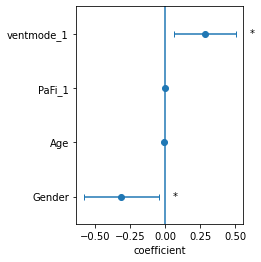

In [168]:
import bone
reload(bone)
df=DFMV
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,4))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
#plt.xscale('symlog')
#ax.set_xlim([-10, 10])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("MV_bulk.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [171]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/test.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()
#ana.getYang2020()#BULK
#ana.getAmado1TT()
ana.getAmado2T()

#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

#atype = ana.h.getSurvName('MDA5_PBMC')
#ahash = {'0':0, '1':1}
#df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

wt1, l1 = [1], [['IFIH1']]
ana.orderData(l1, wt1)
df['C1'] = [None, None] + list(ana.f_ranks)
df['C1'] = np.array(df['C1']).astype(float)

atype = ana.h.getSurvName('sex')
ahash = {'1':1, '0':0}
df['Gender'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('c corticosteroids treatment (ch1)')
ahash = {'1':1, '0':0}
df['corticosteroids'] = [ahash[k] if k in ahash else None for k in atype]

atype = ana.h.getSurvName('age')
ahash = {'age':0, '11':0}
df['Age'] = [ahash[k] if k in ahash else float(k) for k in atype]

atype = ana.h.getSurvName('PaFi_1')
ahash = {'PaFi_1':0, 'NA':0}
df['PaFi_1'] = [ahash[k] if k in ahash else float(k) for k in atype]

wt1, l1 = bone.getViP()
ana.orderData(l1, wt1)
df['sig'] = [None, None] + list(ana.f_ranks)
df['sig'] = np.array(df['sig']).astype(float)

atype = ana.h.getSurvName('c ifih1-rs1990760 (ch1)')
ahash = {'TT':0, 'CT':1, 'CC':1}
df['Genotype'] = [ahash[k] if k in ahash else None for k in atype]

#wt1, l1 = [1], [['CDX2']]
#ana.orderData(l1, wt1)
#df['cdx2'] = [None, None] + list(ana.f_ranks)
#df['cdx2'] = np.array(df['cdx2']).astype(float)

#df1 = pd.DataFrame()
#atype = ana.h.getSurvName('c Sex')
#ahash = {'Female':0, 'Male':1}
#df1['Gender'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df1 = df1.drop(labels=[0,1], axis=0)


#df3 = pd.DataFrame()
#atype = ana.h.getSurvName('c cimp.status')
#ahash = {'-':0, '+':1}
#df3['cimp'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df3 = df3.drop(labels=[0,1], axis=0)

#df4 = pd.DataFrame()
#atype = ana.h.getSurvName('c tp53.mutation')
#ahash = {'WT':0, 'M':1}
#df4['tp53'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df4 = df4.drop(labels=[0,1], axis=0)

#df5 = pd.DataFrame()
#atype = ana.h.getSurvName('c kras.mutation')
#ahash = {'WT':0, 'M':1}
#df5['kras'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
#df5 = df5.drop(labels=[0,1], axis=0)

#DF=pd.concat([df, df1, df3, df4, df5], axis=1)

df = df.drop(labels=[0,1], axis=0)

df=df.loc[df['Genotype'] == 0.0]

#DF
#Udf1 = bone.printOLS("C1 ~ location", DF)
#Udf2 = bone.printOLS("C1 ~ Gender", DF)
#Udf3 = bone.printOLS("C1 ~ cimp", DF)
#Udf4 = bone.printOLS("C1 ~ tp53", DF)
#Udf5 = bone.printOLS("C1 ~ kras", DF)
#df6 = bone.printOLS("C1 ~ sig", DF)
#Udf7 = bone.printOLS("C1 ~ cdx2", DF)
#DF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6, Udf7], axis=0)

DFMV=bone.printOLS("C1 ~ Gender + Age + PaFi_1 + corticosteroids", df)
DFMV

Amado2 (n = 21)
GSE177025 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=SS67
11 [4, 4, 3] GSE177025 http://hegemon.ucsd.edu/Tools/explore.php?key=polyps&id=SS67 SS67
[1]
[147]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                 -0.861
Method:                 Least Squares   F-statistic:                    0.1902
Date:                Fri, 19 May 2023   Prob (F-statistic):              0.929
Time:                        15:18:07   Log-Likelihood:                0.18299
No. Observations:                   8   AIC:                             9.634
Df Residuals:                       3   BIC:                             10.03
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      co

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8


,Name,coeff,lower 0.95,upper 0.95,pvalues,codes
Intercept,Intercept,-2.778317,-12.525041,6.968407,0.431198,
Gender,Gender,-0.054423,-1.082620,0.973774,0.876947,
Age,Age,0.039972,-0.128391,0.208335,0.504823,
PaFi_1,PaFi_1,-0.000554,-0.007828,0.006720,0.824049,
corticosteroids,corticosteroids,0.016751,-0.909347,0.942849,0.957716,


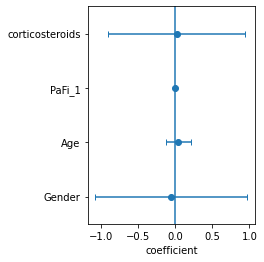

In [172]:
import bone
reload(bone)
df=DFMV
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,4))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("MV_bulk.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [5]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/test.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getMarisa2013()#SC


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('status')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

atype = ana.h.getSurvName('c tumor.location')
ahash = {'proximal':1, 'distal':0}
df['location'] = [ahash[k] if k in ahash else None for k in atype]


wt1, l1 = [1], [bone.getEntries("prodiff_test.txt", 0)]
ana.orderData(l1, wt1)
df['sig'] = [None, None] + list(ana.f_ranks)
df['sig'] = np.array(df['sig']).astype(float)

wt1, l1 = [1], [['CDX2']]
ana.orderData(l1, wt1)
df['cdx2'] = [None, None] + list(ana.f_ranks)
df['cdx2'] = np.array(df['cdx2']).astype(float)

df1 = pd.DataFrame()
atype = ana.h.getSurvName('c Sex')
ahash = {'Female':0, 'Male':1}
df1['Gender'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df1 = df1.drop(labels=[0,1], axis=0)


df3 = pd.DataFrame()
atype = ana.h.getSurvName('c cimp.status')
ahash = {'-':0, '+':1}
df3['cimp'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df3 = df3.drop(labels=[0,1], axis=0)

df4 = pd.DataFrame()
atype = ana.h.getSurvName('c tp53.mutation')
ahash = {'WT':0, 'M':1}
df4['tp53'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df4 = df4.drop(labels=[0,1], axis=0)

df5 = pd.DataFrame()
atype = ana.h.getSurvName('c kras.mutation')
ahash = {'WT':0, 'M':1}
df5['kras'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df5 = df5.drop(labels=[0,1], axis=0)

df6 = pd.DataFrame()
atype = ana.h.getSurvName('c braf.mutation')
ahash = {'WT':0, 'M':1}
df6['braf'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df6 = df6.drop(labels=[0,1], axis=0)

DF=pd.concat([df, df1, df3, df4, df5, df6], axis=1)
DF1=DF.loc[DF['kras'] == 0]

Udf1 = bone.printOLS("C1 ~ location", DF1)
Udf2 = bone.printOLS("C1 ~ Gender", DF1)
Udf3 = bone.printOLS("C1 ~ cimp", DF1)
Udf4 = bone.printOLS("C1 ~ tp53", DF1)
Udf6 = bone.printOLS("C1 ~ sig", DF1)
Udf7 = bone.printOLS("C1 ~ cdx2", DF1)
Udf8 = bone.printOLS("C1 ~ braf", DF1)
UDF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf6, Udf7, Udf8], axis=0)

Marisa 2013 Colon Cancer (n = 585)
GSE39582 http://hegemon.ucsd.edu/Tools/explore.php?key=colon&id=CRC54
574 [395, 179] GSE39582 http://hegemon.ucsd.edu/Tools/explore.php?key=colon&id=CRC54 CRC54
[88]
[1]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.7507
Date:                Fri, 30 Sep 2022   Prob (F-statistic):              0.387
Time:                        11:45:40   Log-Likelihood:                -208.97
No. Observations:                 317   AIC:                             421.9
Df Residuals:                     315   BIC:                             429.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

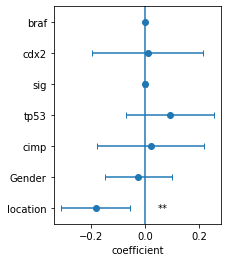

In [144]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,4))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("UV_KRAS_WT.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [5]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/test.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getMarisa2013()#SC


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('status')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]

atype = ana.h.getSurvName('c tumor.location')
ahash = {'proximal':1, 'distal':0}
df['location'] = [ahash[k] if k in ahash else None for k in atype]


wt1, l1 = [1], [bone.getEntries("prodiff_test.txt", 0)]
ana.orderData(l1, wt1)
df['sig'] = [None, None] + list(ana.f_ranks)
df['sig'] = np.array(df['sig']).astype(float)

wt1, l1 = [1], [['CDX2']]
ana.orderData(l1, wt1)
df['cdx2'] = [None, None] + list(ana.f_ranks)
df['cdx2'] = np.array(df['cdx2']).astype(float)

df1 = pd.DataFrame()
atype = ana.h.getSurvName('c Sex')
ahash = {'Female':0, 'Male':1}
df1['Gender'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df1 = df1.drop(labels=[0,1], axis=0)


df3 = pd.DataFrame()
atype = ana.h.getSurvName('c cimp.status')
ahash = {'-':0, '+':1}
df3['cimp'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df3 = df3.drop(labels=[0,1], axis=0)

df4 = pd.DataFrame()
atype = ana.h.getSurvName('c tp53.mutation')
ahash = {'WT':0, 'M':1}
df4['tp53'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df4 = df4.drop(labels=[0,1], axis=0)

df5 = pd.DataFrame()
atype = ana.h.getSurvName('c kras.mutation')
ahash = {'WT':0, 'M':1}
df5['kras'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df5 = df5.drop(labels=[0,1], axis=0)

DF=pd.concat([df, df1, df3, df4, df5], axis=1)


#df = df.drop(lasbels=[0,1], axis=0)
DFMV=bone.printOLS("C1 ~ location + Gender + cimp + tp53 + kras + sig + cdx2", DF)
#Udf1 = bone.printOLS("C1 ~ location", DF)
#Udf2 = bone.printOLS("C1 ~ Gender", DF)
#Udf3 = bone.printOLS("C1 ~ cimp", DF)
#Udf4 = bone.printOLS("C1 ~ tp53", DF)
#Udf5 = bone.printOLS("C1 ~ kras", DF)
#Udf6 = bone.printOLS("C1 ~ sig", DF)
#Udf7 = bone.printOLS("C1 ~ cdx2", DF)
#DF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6, Udf7], axis=0)

Marisa 2013 Colon Cancer (n = 585)
GSE39582 http://hegemon.ucsd.edu/Tools/explore.php?key=colon&id=CRC54
574 [395, 179] GSE39582 http://hegemon.ucsd.edu/Tools/explore.php?key=colon&id=CRC54 CRC54
[88]
[1]
                            OLS Regression Results                            
Dep. Variable:                     C1   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.019
Date:                Fri, 30 Sep 2022   Prob (F-statistic):              0.418
Time:                        00:49:15   Log-Likelihood:                -188.76
No. Observations:                 287   AIC:                             393.5
Df Residuals:                     279   BIC:                             422.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
     

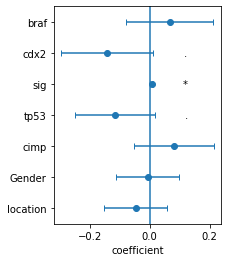

In [6]:
import bone
reload(bone)
df=UDF
df = df.drop(['Intercept'])
#df = df.sort_values('pvalues',ascending=False)
plt.figure(figsize=(3,4))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.errorbar(df["coeff"], range(len(df.index)),
    yerr=0,
    xerr=[list(df["coeff"] - df["lower 0.95"]), list(df["upper 0.95"] - df["coeff"])],
    fmt='o', capsize=3, color='tab:blue')
ax.set_yticks(range(len(df.index)))
ax.set_yticklabels(df["Name"])
ax.set_xlabel("coefficient")
ax.axvline(x=0, color='tab:blue')
#ax.set_xlim([0, 5.5])
ax.set_ylim([-0.5, len(df.index) - 0.5])
for i in range(len(df.index)):
    ax.text(df["upper 0.95"][i] + 0.1,i, df['codes'][i], verticalalignment='center')
#ax.set_title("GSE122401")
pdf = getPDF("MV_Marisa.pdf")
pdf.savefig(transparent=True,bbox_inches = 'tight')
closePDF(pdf)

In [7]:
import bone
reload(bone)
cfile = "/Users/sinha7290/public_html/BoNE/test.pdf"
pdf = getPDF(cfile)
ana = MacAnalysis()
#ana.getYang2020()#BULK
ana.getJSTOM()#SC


#ana.order = [i for i in ana.h.aRange()]
df = pd.DataFrame()

atype = ana.h.getSurvName('status')
ahash = {'0':0, '1':1}
df['C1'] = [ahash[k] if k in ahash else None for k in atype]
#df['C1'] = [k for k in atype]


wt1, l1 = [1], [bone.getEntries("prodiff_test.txt", 0)]
ana.orderData(l1, wt1)
df['sig'] = [None, None] + list(ana.f_ranks)
df['sig'] = np.array(df['sig']).astype(float)

wt1, l1 = [1], [['CDX2']]
ana.orderData(l1, wt1)
df['cdx2'] = [None, None] + list(ana.f_ranks)
df['cdx2'] = np.array(df['cdx2']).astype(float)

df1 = pd.DataFrame()
atype = ana.h.getSurvName('c Sex')
ahash = {'Female':0, 'Male':1}
df1['Gender'] = [ahash[atype[i]] if atype[i] in ahash else None for i in ana.i1]
df1 = df1.drop(labels=[0,1], axis=0)


DF=pd.concat([df, df1], axis=1)


#df = df.drop(lasbels=[0,1], axis=0)
DF
Udf1 = bone.printOLS("C1 ~ location", DF)
Udf2 = bone.printOLS("C1 ~ Gender", DF)
Udf3 = bone.printOLS("C1 ~ cimp", DF)
Udf4 = bone.printOLS("C1 ~ tp53", DF)
Udf5 = bone.printOLS("C1 ~ kras", DF)
Udf6 = bone.printOLS("C1 ~ sig", DF)
Udf7 = bone.printOLS("C1 ~ cdx2", DF)
DF=pd.concat([Udf1, Udf2, Udf3, Udf4, Udf5, Udf6, Udf7], axis=0)

AttributeError: 'MacAnalysis' object has no attribute 'getJSTOM'